# Song mood prediction using shallow models

# Objective: Predicting valence of songs

### What is valence?

Score used to objectively define the musical positiveness of a song, including lyrics, instruments and the audio itself.

### What are shallow models?

Contrary to the commonly mentioned deep learning models, shallow models use lower ammount of features created from the raw data.

### Why is this study relevant?

Valence prediciton can be used on music platforms to create playlists, suggest songs based on moods (e.g. for different moments of the day) and help in identifying similar songs.

Data from different sources were used in this study, so this could be used as a4 comparative study about data quality for training of shallow models.

# Methodology

### Decide what kind of data will be used

We opted to extract features from raw audio data, so valence scores can be predicted even for instrumental songs.

### Find data on the internet

We used both the Spotify API for developers and the Dataset for Emotional Analysis of Music (DEAM).

Spotify API is widely available, it has valence and audio previews for any song on the platform.

DEAM has been used in scientific articles as a dataset for model training and it is a reliable source. Songs may not be commercial or famous.

### Extract features

Feature extraction methods were found in the literature for raw audio data using the Librosa module. We tried to replicate methods by using:

- Chroma
- RMS Energy
- Spectral Centroid
- Rolloff
- Zero Cross Ratings
- Mel-frequency Ceptrum Coefficient

We took the means and variances of both these signals and their first order differentiation signals.


### Analyze the data (EDA) and Train Models

In [ ]:
from google.colab import drive
# mounting google drive to access data file
drive.mount('/content/drive')

In [ ]:
# Import spotipy for easy access to the spotify API
!pip install spotipy --quiet
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

# Import python stuff
import requests
import shutil
import numpy as np
import pandas as pd
import os
import os.path as path
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import warnings
import joblib
import yaml
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import minmax_scale

# Import librosa for audio processing
import librosa
import librosa.display

In [ ]:
# importing features and train files
x_train = pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/X_train.csv', index_col = 'Unnamed: 0')
x_test =  pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/X_test.csv', index_col = 'Unnamed: 0')
x_valid =  pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/X_valid.csv', index_col = 'Unnamed: 0')
y_train = pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/Y_train.csv', index_col = 'Unnamed: 0')
y_test =  pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/Y_test.csv', index_col = 'Unnamed: 0')
y_valid =  pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/Y_valid.csv', index_col = 'Unnamed: 0')

print('Feature Data')
print('x train shape: ', x_train.shape)
print('x test shape', x_test.shape)
print('x valid shape', x_valid.shape)
print()
print('Target Data')
print('y train shape: ', y_train.shape)
print('y test shape', y_test.shape)
print('y valid shape', y_valid.shape)


Feature Data
x train shape:  (1196, 104)
x test shape (298, 104)
x valid shape (298, 104)

Target Data
y train shape:  (1196, 1)
y test shape (298, 1)
y valid shape (298, 1)


Below is a least of every feature considered for model training.

In [ ]:
x_train.columns.values

array(['chroma_mean', 'chroma_var', 'chroma_meandif', 'chroma_vardif',
       'rmse_mean', 'rmse_var', 'rmse_meandif', 'rmse_vardif',
       'spec_cent_mean', 'spec_cent_var', 'spec_cent_meandif',
       'spec_cent_vardif', 'spec_bw_mean', 'spec_bw_var',
       'spec_bw_meandif', 'spec_bw_vardif', 'rolloff_mean', 'rolloff_var',
       'rolloff_meandif', 'rolloff_vardif', 'zcr_mean', 'zcr_var',
       'zcr_meandif', 'zcr_vardif', 'mfcc0_mean', 'mfcc0_var',
       'mfcc0_meandif', 'mfcc0_vardif', 'mfcc1_mean', 'mfcc1_var',
       'mfcc1_meandif', 'mfcc1_vardif', 'mfcc2_mean', 'mfcc2_var',
       'mfcc2_meandif', 'mfcc2_vardif', 'mfcc3_mean', 'mfcc3_var',
       'mfcc3_meandif', 'mfcc3_vardif', 'mfcc4_mean', 'mfcc4_var',
       'mfcc4_meandif', 'mfcc4_vardif', 'mfcc5_mean', 'mfcc5_var',
       'mfcc5_meandif', 'mfcc5_vardif', 'mfcc6_mean', 'mfcc6_var',
       'mfcc6_meandif', 'mfcc6_vardif', 'mfcc7_mean', 'mfcc7_var',
       'mfcc7_meandif', 'mfcc7_vardif', 'mfcc8_mean', 'mfcc8_var',
    

These are the Pearon correlation values for every feature.

In [ ]:
x_train.join(y_train).corr()['valence_mean'].sort_values(ascending=False)[1:].head(20)

mfcc0_mean        0.564614
rolloff_mean      0.547272
spec_cent_mean    0.524815
spec_bw_mean      0.509111
chroma_vardif     0.411423
zcr_mean          0.384039
mfcc13_mean       0.363900
mfcc7_mean        0.355339
mfcc9_mean        0.349365
mfcc16_vardif     0.343538
mfcc15_mean       0.334761
mfcc17_vardif     0.332201
mfcc14_vardif     0.330344
mfcc17_mean       0.327830
mfcc15_vardif     0.326495
mfcc11_mean       0.321137
mfcc18_vardif     0.320691
mfcc13_vardif     0.312322
mfcc8_vardif      0.304462
mfcc12_vardif     0.302653
Name: valence_mean, dtype: float64

The graph below shows that data has been correctly distributed between training, testing and validation datasets.

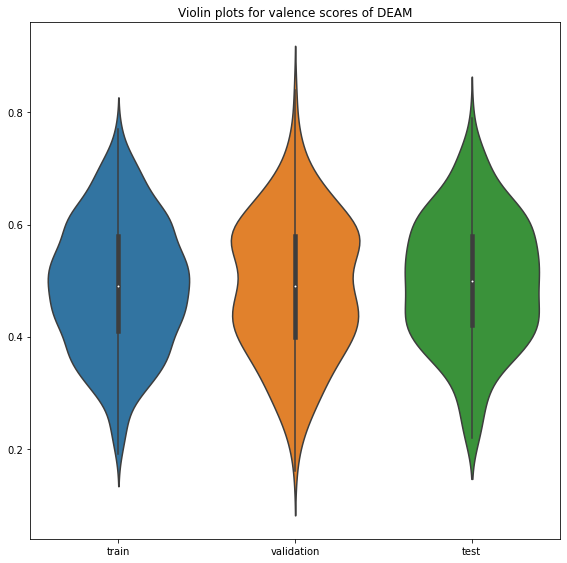

In [ ]:
plt.figure(figsize=(9.5,9.5))
sns.violinplot(data=[y_train, y_valid, y_test])
ax = plt.gca()
ax.set_xticklabels(labels=['train', 'validation', 'test'])
ax.set_title('Violin plots for valence scores of DEAM')
plt.show()

In [ ]:
# importing features and train files
spotify_x_train = pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/spotify_X_train.csv', index_col = 'Unnamed: 0')
spotify_x_test =  pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/spotify_X_test.csv', index_col = 'Unnamed: 0')
spotify_x_valid =  pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/spotify_X_valid.csv', index_col = 'Unnamed: 0')
spotify_y_train = pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/spotify_Y_train.csv', index_col = 'Unnamed: 0')
spotify_y_test =  pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/spotify_Y_test.csv', index_col = 'Unnamed: 0')
spotify_y_valid =  pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/spotify_Y_valid.csv', index_col = 'Unnamed: 0')

print('Feature Data')
print('x train shape: ', spotify_x_train.shape)
print('x test shape', spotify_x_test.shape)
print('x valid shape', spotify_x_valid.shape)
print()
print('Target Data')
print('y train shape: ', spotify_y_train.shape)
print('y test shape', spotify_y_test.shape)
print('y valid shape', spotify_y_valid.shape)

Feature Data
x train shape:  (1084, 156)
x test shape (272, 156)
x valid shape (270, 156)

Target Data
y train shape:  (1084, 1)
y test shape (272, 1)
y valid shape (270, 1)


Since valence is prone to subjective error, it is valid to analyze distributions of both datasets.
The probability distributions for both datasets are very different from each other.
Spotify is reportedly considered less reliable.

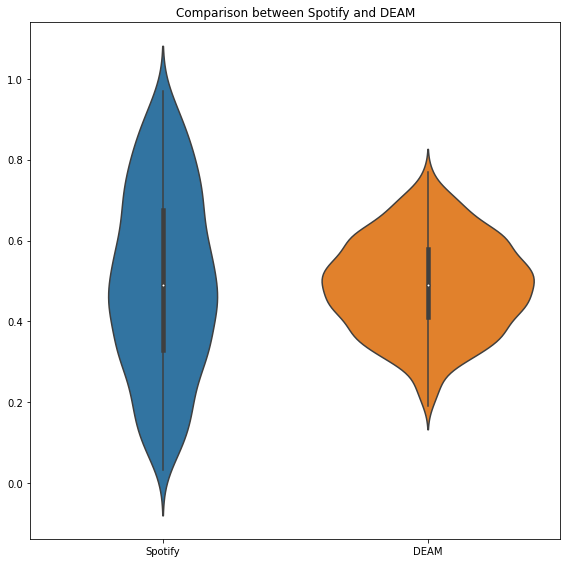

In [ ]:
plt.figure(figsize=(9.5,9.5))
sns.violinplot(data=[spotify_y_train, y_train])
ax = plt.gca()
ax.set_xticklabels(['Spotify', 'DEAM'])
ax.set_title('Comparison between Spotify and DEAM')
plt.show()

We will try several models for machine learning training.

In [ ]:
#libraries used for training
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
!pip install catboost
import catboost

Model 0: Linear Regression Model

In [ ]:
# defining feature, target, validation variables for model
features_train_0 = x_train
features_valid_0 = x_valid
features_test_0 = x_test

target_train_0 = y_train
target_valid_0 = y_valid
target_test_0 = y_test

In [ ]:
model_0 = lr()
model_0.fit(features_train_0, target_train_0)
predicted_0 = model_0.predict(features_valid_0)


mse_0 = mean_squared_error(predicted_0, target_valid_0)
rmse_0 = math.sqrt(mse_0)
mae_0 = mean_absolute_error(predicted_0, target_valid_0)
print('mae_0 :', mae_0)
print('rmse_0 :', rmse_0)

Model_0b: Linear Regression Model, Normalized Features


In [ ]:
all_features = pd.concat([x_train, x_valid, x_test])
print('all features shape',all_features.shape)

#norm
scaler_0b = StandardScaler()
scaler_0b.fit(all_features)

features_train_0b = scaler_0b.transform(features_train_0)
features_valid_0b = scaler_0b.transform(features_valid_0)
features_test_0b = scaler_0b.transform(features_test_0)

target_train_0b = target_train_0
target_valid_0b = target_valid_0
target_test_0 = target_test_0

In [ ]:
model_0b = lr()
model_0b.fit(features_train_0b, target_train_0b)
predicted_0b = model_0b.predict(features_valid_0b)


mse_0b = mean_squared_error(predicted_0b, target_valid_0b)
rmse_0b = math.sqrt(mse_0b)
mae_0b = mean_absolute_error(predicted_0b, target_valid_0b)
print('mae_0b :', mae_0b)
print('rmse_0b :', rmse_0b)

Model 1: XGBoost Regressor

In [ ]:
# defining feature, target, validation variables for model
features_train_1 = x_train
features_valid_1 = x_valid
features_test_1 = x_test

target_train_1 = y_train
target_valid_1 = y_valid
target_test_1 = y_test

In [ ]:
#using RandomizedSearchCV for hyper parameter tuning

params_1 = {'booster' : ['gbtree', 'gblinear'],
         'eta' : list(np.arange(0.01, 0.3, 0.01)),
         'max_depth': list(range(3,11)),
         'gamma': list(range(1,11)),
         'min_child_weight' : list(range(1,11))}

In [ ]:
model_1 = xgb.XGBRegressor(seed=12345)

rscv_1 = RandomizedSearchCV(estimator=model_1, param_distributions = params_1, cv=4, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_1.fit(features_train_1, target_train_1)

In [ ]:
rscv_1.best_params_

In [ ]:
model_1v = xgb.XGBRegressor(seed=12345,
                            booster = rscv_1.best_params_['booster'],
                            eta = rscv_1.best_params_['eta'],
                            max_depth = rscv_1.best_params_['max_depth'],
                            gamma = rscv_1.best_params_['gamma'],
                            min_child_weight = rscv_1.best_params_['min_child_weight'])

model_1v.fit(features_train_1, target_train_1)
predicted_1 = model_1v.predict(features_valid_1)
rmse_1 = math.sqrt(mean_squared_error(predicted_1, target_valid_1))
mae_1 = mean_absolute_error(predicted_1, target_valid_1)

print('mae_1 :', mae_1)
print('rmse_1 :', rmse_1)

Model 1b: XGboost Regressor, Normalized Features

In [ ]:
# defining training, validation, and testing varaibles

features_train_1b = scaler_0b.transform(features_train_0)
features_valid_1b = scaler_0b.transform(features_valid_0)
features_test_1b = scaler_0b.transform(features_test_0)

target_train_1b = target_train_0
target_valid_1b = target_valid_0
target_test_1b = target_test_0

In [ ]:
#using RandomizedSearchCV for hyper parameter tuning

params_1b = {'booster' : ['gbtree', 'gblinear'],
         'eta' : list(np.arange(0.01, 0.3, 0.01)),
         'max_depth': list(range(3,11)),
         'gamma': list(range(1,11)),
         'min_child_weight' : list(range(1,11))}

In [ ]:
model_1b = xgb.XGBRegressor(seed=12345)

rscv_1b = RandomizedSearchCV(estimator=model_1b, param_distributions = params_1b, cv=4, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_1b.fit(features_train_1b, target_train_1b)

In [ ]:
rscv_1b.best_params_

In [ ]:
model_1vb = xgb.XGBRegressor(seed=12345,
                            booster = rscv_1b.best_params_['booster'],
                            eta = rscv_1b.best_params_['eta'],
                            max_depth = rscv_1b.best_params_['max_depth'],
                            gamma = rscv_1b.best_params_['gamma'],
                            min_child_weight = rscv_1b.best_params_['min_child_weight'])

model_1vb.fit(features_train_1b, target_train_1b)
predicted_1b = model_1vb.predict(features_valid_1b)
rmse_1b = math.sqrt(mean_squared_error(predicted_1b, target_valid_1b))
mae_1b = mean_absolute_error(predicted_1b, target_valid_1b)

print('mae_1b :', mae_1b)
print('rmse_1b :', rmse_1b)

Model 2: Support Vector Regressor

In [ ]:
# defining feature, target, validation variables for model
features_train_2 = x_train
features_valid_2 = x_valid
features_test_2 = x_test

target_train_2 = y_train
target_valid_2 = y_valid
target_test_2 = y_test

In [ ]:
#using RandomizedSearchCV for hyper parameter tuning

params_2 = {'kernel' : ['rbf'],
            'gamma' : list(np.arange(0.001, 10.1, 0.1)),
            'C' : list(np.arange(0.1, 100.1, 0.1)),
            'epsilon' : list(np.arange(0.1, 0.5, 0.1))}

params_2['gamma'].append('scale')
params_2['gamma'].append('auto')

In [ ]:
model_2 = SVR()

rscv_2 = RandomizedSearchCV(estimator=model_2, param_distributions = params_2, cv=3, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_2.fit(features_train_2, target_train_2)

In [ ]:
rscv_2.best_params_

In [ ]:
model_2v = SVR(kernel = rscv_2.best_params_['kernel'],
               gamma = rscv_2.best_params_['gamma'],
               epsilon = rscv_2.best_params_['epsilon'],
               C = rscv_2.best_params_['C'])

model_2v.fit(features_train_2, target_train_2)
predicted_2 = model_2v.predict(features_valid_2)
rmse_2 = math.sqrt(mean_squared_error(predicted_2, target_valid_2))
mae_2 = mean_absolute_error(predicted_2, target_valid_2)

print('mae_2 :', mae_2)
print('rmse_2 :', rmse_2)

Model 2b: Support Vector Regressor, Normalized Data

In [ ]:
# defining training, validation, and testing varaibles

features_train_2b = scaler_0b.transform(features_train_0)
features_valid_2b = scaler_0b.transform(features_valid_0)
features_test_2b = scaler_0b.transform(features_test_0)

target_train_2b = target_train_0
target_valid_2b = target_valid_0
target_test_2b = target_test_0

In [ ]:
#using RandomizedSearchCV for hyper parameter tuning

params_2b = {'kernel' : ['rbf'],
            'gamma' : list(np.arange(0.001, 10.1, 0.1)),
            'C' : list(np.arange(0.1, 100.1, 0.1)),
            'epsilon' : list(np.arange(0.1, 0.5, 0.1))}

params_2b['gamma'].append('scale')
params_2b['gamma'].append('auto')

In [ ]:
model_2b = SVR()

rscv_2b = RandomizedSearchCV(estimator=model_2b, param_distributions = params_2b, cv=3, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_2b.fit(features_train_2b, target_train_2b)

In [ ]:
model_2vb = SVR(kernel = rscv_2b.best_params_['kernel'],
               gamma = rscv_2b.best_params_['gamma'],
               epsilon = rscv_2b.best_params_['epsilon'],
               C = rscv_2b.best_params_['C'])

model_2vb.fit(features_train_2b, target_train_2b)
predicted_2b = model_2vb.predict(features_valid_2b)
rmse_2b = math.sqrt(mean_squared_error(predicted_2b, target_valid_2b))
mae_2b = mean_absolute_error(predicted_2b, target_valid_2b)

print('mae_2b :', mae_2b)
print('rmse_2b :', rmse_2b)

Model 3: K-Nearest Neighbors Regressor

In [ ]:
# defining feature, target, validation variables for model
features_train_3 = x_train
features_valid_3 = x_valid
features_test_3 = x_test

target_train_3 = y_train
target_valid_3 = y_valid
target_test_3 = y_test

In [ ]:
#using RandomizedSearchCV for hyper parameter tuning

params_3 = {'n_neighbors' : list(range(1,50)),
            'weights' : ['uniform', 'distance'],
            'p' : [1,2],
            'metric' : ['l1','l2']}

In [ ]:
model_3 = KNeighborsRegressor()

rscv_3 = RandomizedSearchCV(estimator=model_3, param_distributions = params_3, cv=4, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_3.fit(features_train_3, target_train_3)

In [ ]:
rscv_3.best_params_

In [ ]:
model_3v = KNeighborsRegressor(weights = rscv_3.best_params_['weights'],
                               p= rscv_3.best_params_['p'],
                               n_neighbors= rscv_3.best_params_['n_neighbors'],
                               metric = rscv_3.best_params_['metric'])

model_3v.fit(features_train_3, target_train_3)
predicted_3 = model_3v.predict(features_valid_3)
rmse_3 = math.sqrt(mean_squared_error(predicted_3, target_valid_3))
mae_3 = mean_absolute_error(predicted_3, target_valid_3)

print('mae_3 :', mae_3)
print('rmse_3 :', rmse_3)

Model 3b: K-Nearest Neighbors Regressor, Normalized Data


In [ ]:
# defining training, validation, and testing varaibles

features_train_3b = scaler_0b.transform(features_train_0)
features_valid_3b = scaler_0b.transform(features_valid_0)
features_test_3b = scaler_0b.transform(features_test_0)

target_train_3b = target_train_0
target_valid_3b = target_valid_0
target_test_3b = target_test_0

In [ ]:
#using RandomizedSearchCV for hyper parameter tuning

params_3b = {'n_neighbors' : list(range(1,50)),
            'weights' : ['uniform', 'distance'],
            'p' : [1,2],
            'metric' : ['l1','l2']}

In [ ]:
model_3b = KNeighborsRegressor()

rscv_3b = RandomizedSearchCV(estimator=model_3b, param_distributions = params_3b, cv=4, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_3b.fit(features_train_3b, target_train_3b)

In [ ]:
rscv_3b.best_params_

In [ ]:
model_3vb = KNeighborsRegressor(weights = rscv_3b.best_params_['weights'],
                               p= rscv_3b.best_params_['p'],
                               n_neighbors= rscv_3b.best_params_['n_neighbors'],
                               metric = rscv_3b.best_params_['metric'])

model_3vb.fit(features_train_3b, target_train_3b)
predicted_3b = model_3vb.predict(features_valid_3b)
rmse_3b = math.sqrt(mean_squared_error(predicted_3b, target_valid_3b))
mae_3b = mean_absolute_error(predicted_3b, target_valid_3b)

print('mae_3b :', mae_3b)
print('rmse_3b :', rmse_3b)

Model 4: CatBoost Regressor

In [ ]:
# defining feature, target, validation variables for model
features_train_4 = x_train
features_valid_4 = x_valid
features_test_4 = x_test

target_train_4 = y_train
target_valid_4 = y_valid
target_test_4 = y_test

In [ ]:
model_4 = catboost.CatBoostRegressor(random_state=1995, loss_function='RMSE')
params_4 = {
    'depth': list(range(3,11,2)),
    'learning_rate': [0.003,0.01],
    'iterations': [
         #500,
         700,
         #1000,
         #1500,
        #2000
        ]
}

In [ ]:
rscv_4 = RandomizedSearchCV(estimator=model_4, param_distributions = params_4, cv=3, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_4.fit(features_train_4, target_train_4)

In [ ]:
rscv_4.best_params_

In [ ]:
model_4v = catboost.CatBoostRegressor(learning_rate = rscv_4.best_params_['learning_rate'],
                               iterations = rscv_4.best_params_['iterations'],
                               depth= rscv_4.best_params_['depth'])

model_4v.fit(features_train_4, target_train_4)
predicted_4 = model_4v.predict(features_valid_4)
rmse_4 = math.sqrt(mean_squared_error(predicted_4, target_valid_4))
mae_4 = mean_absolute_error(predicted_4, target_valid_4)



In [ ]:
print('mae_4 :', mae_4)
print('rmse_4 :', rmse_4)

Model 4b: CatboostRegressor, Normalized Data

In [ ]:
# defining training, validation, and testing varaibles

features_train_4b = scaler_0b.transform(features_train_0)
features_valid_4b = scaler_0b.transform(features_valid_0)
features_test_4b = scaler_0b.transform(features_test_0)

target_train_4b = target_train_0
target_valid_4b = target_valid_0
target_test_4b = target_test_0

In [ ]:
model_4b = catboost.CatBoostRegressor(random_state=1995, loss_function='RMSE')
params_4b = {
    'depth': list(range(3,11,2)),
    'learning_rate': list(np.arange(0.001, 1, 0.01)),
    'iterations': [
         #500,
         700,
         #1000,
         #1500,
        #2000
        ]
}

In [ ]:
rscv_4b = RandomizedSearchCV(estimator=model_4b, param_distributions = params_4b, cv=3, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_4b.fit(features_train_4b, target_train_4b)

In [ ]:
rscv_4b.best_params_

In [ ]:
model_4vb = catboost.CatBoostRegressor(learning_rate = rscv_4b.best_params_['learning_rate'],
                               iterations = rscv_4b.best_params_['iterations'],
                               depth= rscv_4b.best_params_['depth'])

model_4vb.fit(features_train_4b, target_train_4b)
predicted_4b = model_4vb.predict(features_valid_4b)
rmse_4b = math.sqrt(mean_squared_error(predicted_4b, target_valid_4b))
mae_4b = mean_absolute_error(predicted_4b, target_valid_4b)



### Performance Results and Selection of best Model

In [ ]:
# printing results with validation data to select best model for testing

val_results = { 'model_description' : ['linear regression', 'linear regression, normalized features',
                                       'XGBoost regressor', ' XGBoost regressor, normalized features',
                                       'support vector regressor', 'support vector regressor, normalized features',
                                       'k-nearest neighbors regressor', 'k-nearest neighbors regressor, normalized features',
                                       'catboost regressor', 'catboost regressor, normalized features'],

              'model': [model_0, model_0b, model_1, model_1b, model_2, model_2b, model_3, model_3b, model_4, model_4b],

               'rmse' : [rmse_0, rmse_0b, rmse_1, rmse_1b, rmse_2, rmse_2b,
                         rmse_3, rmse_3b, rmse_4, rmse_4b],

               'mae'  : [mae_0, mae_0b, mae_1, mae_1b, mae_2, mae_2b,
                         mae_3, mae_3b, mae_4, mae_4b]}

v_results = pd.DataFrame.from_dict(val_results,orient='index').transpose()
v_results.sort_values('rmse', ascending=True)

,model_description,model,rmse,mae
8,catboost regressor,<catboost.core.CatBoostRegressor object at 0x7...,0.083495,0.068551
9,"catboost regressor, normalized features",<catboost.core.CatBoostRegressor object at 0x7...,0.083874,0.067704
0,linear regression,LinearRegression(),0.087565,0.070914
1,"linear regression, normalized features",LinearRegression(),0.087565,0.070914
2,XGBoost regressor,XGBRegressor(seed=12345),0.088296,0.07207
3,"XGBoost regressor, normalized features",XGBRegressor(seed=12345),0.089524,0.07306
7,"k-nearest neighbors regressor, normalized feat...",KNeighborsRegressor(),0.091061,0.072954
6,k-nearest neighbors regressor,KNeighborsRegressor(),0.107722,0.089935
4,support vector regressor,SVR(),0.122508,0.10229
5,"support vector regressor, normalized features",SVR(),0.122508,0.10229


In [ ]:
deam = pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/deam.csv', index_col = 'Unnamed: 0')

lim_up = deam.iloc[[i for i in y_test.index.values]]['valence_mean'] + 0.5*deam.iloc[[i for i in y_test.index.values]]['valence_std']
lim_down = deam.iloc[[i for i in y_test.index.values]]['valence_mean'] - 0.5*deam.iloc[[i for i in y_test.index.values]]['valence_std']

In [ ]:
def plot_ordered(data, keys=None, figsize=(12,12)):
    if keys is None:
        keys = ['data '+str(i) for i in range(len(data))]

    sorted = pd.DataFrame({keys[i]: data[i] for i in range(len(data))}).sort_values(keys[-1], ascending=True).reset_index(drop=True)
    plt.figure(figsize=figsize)
    for i in keys:
        plt.plot(sorted[i])

Prediction made by our final model:

In [ ]:
predicted_test = pd.read_csv('/content/drive/MyDrive/data_project_cuetessa/predicted_test.csv', index_col = 'Unnamed: 0')

In [ ]:
predicted_test.index = y_test.index

In [ ]:
def plot_ordered(data, keys=None, figsize=(12,8)):
    if keys is None:
        keys = ['data '+str(i) for i in range(len(data))]

    sorted = pd.DataFrame({keys[i]: data[i] for i in range(len(data))}).sort_values(keys[-1], ascending=True).reset_index(drop=True)
    plt.figure(figsize=figsize)
    for i in keys:
        plt.plot(sorted[i])

In [ ]:
predicted_test['0']

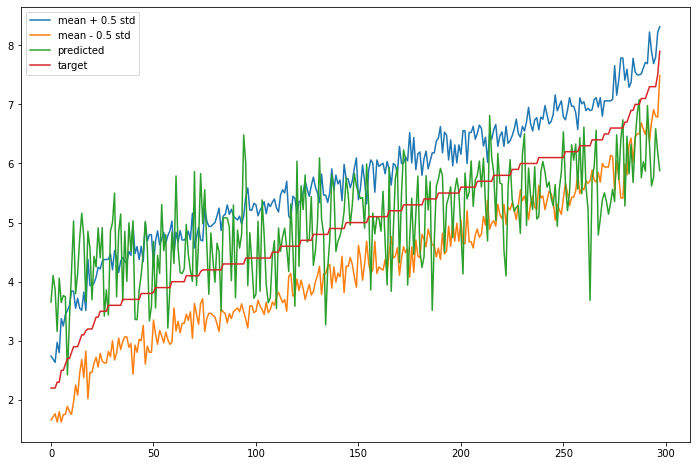

In [ ]:
plot_ordered( [
    lim_up,
    lim_down,
     predicted_test['0']*10,
     y_test['valence_mean']*10] )

plt.legend(['mean + 0.5 std', 'mean - 0.5 std', 'predicted', 'target'])

Although the final predicted result of valence is not satisfactory when compared against the target, it is important to further consider the circumstances of this test. In fact, the audio files for the annotated dataset were not readily available, and spotify data was considered instead. Unfortunately, since the spotify data does not have a reported method of defining valence values, it is possible that they were using a model to assign valence values to their songs.

Unfortunately, considering the flat distribution of valence values of spotify when compared with the annotated dataset, this suggests that our training data is not reliable as a source of information. I.E. if the training dataset has random values assigned to each song, then the model is more likely to behave randomly.

Therefore, the main findings in this project are:

- Spotify data was not a reliable source of information for valence reference.
- Human annotated datasets are extremely important for audio related emotion trainig.
- Valence values tend to behave as a normal distribution.